# 統計的裁定

裁定のように無リスクで収益が得られる機会はないが、無制限に投資期間を延ばせるならリスクの大部分を除去できるような投資戦略のこと。



アプローチは主に2つあるとされる

1. データ分析や統計学を応用
   - 例：共和分法
2. 経済学的な根拠に基づく方法
   - 例：マーケット中立化法

## 共和分法

### 共和分

単位根過程（1次の和分過程）$x,y$があるとする。その線形和$ax+by$が定常過程となるような$a,b$が存在するとき、$x$と$y$の間には共和分の関係があるという。

より一般的には

:::{card} 定義（共和分）

M次元の確率過程$\boldsymbol{X}(t)$は以下を満たすとき**共和分過程**（cointegrated process）と言われる。

1. $\boldsymbol{X}(t)$の各要素は1次の和分過程である
2. $\boldsymbol{b}^\top \boldsymbol{X}(t)$が定常過程となるゼロでないベクトル$\boldsymbol{b}\in \mathbb{R}^M$が存在する

このような$\boldsymbol{b}$を**共和分ベクトル**（cointegrating vector, cointegration vector）とよぶ。
:::


### 共和分過程であるかどうかの判定→共和分検定

**VECM**（vector error correction model)


$$
\Delta \boldsymbol{S}(t)
= \boldsymbol{c} + \alpha \beta^\top \boldsymbol{S}(t-1) + \boldsymbol{Z}(t)
$$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VECM

In [2]:
Sigma = np.array([[1,0,0],[0,1,0],[0,0,1]])

# 配列を生成
alpha_1 = np.array([0.1,0.2,0.3])
alpha_2_ = np.array([0.5,-0.3,-0.3]) 
beta_1 = np.array([1,-0.5,-0.5])
beta_2_ = np.array([-0.2,0.5,-0.2])

# 配列から行列を生成
alpha_2 = np.stack([alpha_1, alpha_2_],axis = 1) # alpha_2
beta_2 = np.stack([beta_1, beta_2_]) # beta_2

# 内積計算
Pi_1 = np.dot(alpha_1.reshape(3,1), beta_1.reshape(1,3))
Pi_2 = np.dot(alpha_2, beta_2)

In [3]:
np.random.seed(seed=1)
rand_nums = np.random.randn(10000, 3)

# ランダム・ウォーク、共和分過程の初期化
init = np.array([1,1,1])
S_rw = init
S_ci1 = init
S_ci2 = init

for rand_num in rand_nums:
    S_rw = np.vstack((S_rw,S_rw[len(S_rw)-1] + np.dot(rand_num,Sigma)))
    S_ci1 = np.vstack((S_ci1,np.dot(Pi_1 + np.eye(3),S_ci1[len(S_ci1)-1]) 
                       + np.dot(rand_num,Sigma)))
    S_ci2 = np.vstack((S_ci2,np.dot(Pi_2 + np.eye(3),S_ci2[len(S_ci2)-1]) 
                       + np.dot(rand_num,Sigma)))



In [4]:
#ランダムウォークに対する共和分検定
JohansenTestResult_rw = coint_johansen(S_rw, k_ar_diff=0, det_order=-1)

In [5]:
# 尤度比（likelihood ratio）
# lr1はtrace testに対する統計量、lr2がmax testに対する統計量
print(JohansenTestResult_rw.lr1) # Trace statistic

[22.58036266  8.78820583  2.43645402]


In [6]:
print(JohansenTestResult_rw.cvt) # Critical values (90%,95%,99%) of trace statistic
# 1行目が「ランクが0である」という帰無仮説のtrace testの棄却限界値
# 2行目は「ランクが1である」

[[21.7781 24.2761 29.5147]
 [10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]


In [7]:
print(JohansenTestResult_rw.lr2) # Maximum eigenvalue statistic

[13.79215683  6.35175181  2.43645402]


In [8]:
print(JohansenTestResult_rw.cvm) # Critical values (90%,95%,99%) of maximum eigenvalue statistic

[[15.7175 17.7961 22.2519]
 [ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]]


[statsmodels.tsa.vector_ar.vecm.VECM — statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.VECM.html)

[statsmodelsによるベクトル誤差修正モデル(VECM)入門 - Qiita](https://qiita.com/innovation1005/items/d53d9ba4f9e8ee1832c6)

In [9]:
# 計算が重くメモリ消費量も多いので注意
model_s1 = VECM(S_rw, k_ar_diff=0, coint_rank = 1, deterministic='na')
res_s1 = model_s1.fit()

In [10]:
print(res_s1.summary())

                 Loading coefficients (alpha) for equation y1                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1           -0.0005      0.000     -2.592      0.010      -0.001      -0.000
                 Loading coefficients (alpha) for equation y2                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1            0.0003      0.000      1.749      0.080   -3.76e-05       0.001
                 Loading coefficients (alpha) for equation y3                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1        -6.855e-05      0.000     -0.382      0.702      -0.000       0.000
          Cointegration relations for loading-coeffi

In [22]:
# 推定されたパラメータ
print(res_s1.alpha)
print(res_s1.beta)

[[-4.65121407e-04]
 [ 3.12031285e-04]
 [-6.85477939e-05]]
[[ 1.        ]
 [-0.81511627]
 [ 0.95993846]]


### 考察

どう使える？どうやって見つけられる？共和分の関係があったとして、将来も続く？

In [ ]:
import matplotlib.pyplot as plt

np.random.seed(seed=1)

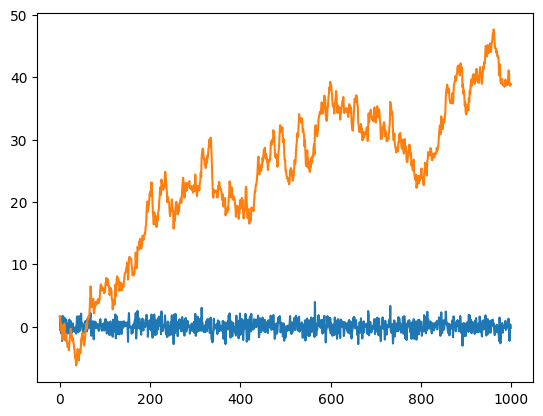

In [20]:
import matplotlib.pyplot as plt

np.random.seed(seed=1)
x = np.random.normal(loc=0, scale=1, size=1000)
rw = np.cumsum(x)  # random walk: y_t = y_{t-1} + e

plt.plot(x)
plt.plot(rw)


## マーケット中立化法

最も一般に知られる意味での「マーケット中立」は、市場ポートフォリオの変動に対してパフォーマンスが左右されないポートフォリオというもの。

例えば2つの危険資産$S_1, S_2$のリターンがCAPMに従い、それぞれ

$$
R_1 = \mu_0 + \beta_1 (R_{\mathcal{M}} - \mu_0) + \epsilon_1\\
R_2 = \mu_0 + \beta_2 (R_{\mathcal{M}} - \mu_0) + \epsilon_2
$$

で変動していたとする。ポートフォリオ・ウェイトを

$$
\boldsymbol{\pi} = (\pi_1, \pi_2)
= \left(
\frac{\beta_2}{\beta_2 - \beta_1},
\frac{-\beta_1}{\beta_2 - \beta_1},
\right)
$$

とすると、ポートフォリオのリターンは

$$
\begin{align}
R_P
&= \pi_1 R_1 + \pi_2 R_2\\
&= \underbrace{(\pi_1 + \pi_2)}_{=1} \mu_0
+ (\pi_1 \beta_1 + \pi_2\beta_2)
(R_{\mathcal{M}} - \mu_0)
+ \pi_1 \epsilon_1 +  \pi_2 \epsilon_2
\\
&= \mu_0
+ \underbrace{(
\frac{\beta_2}{\beta_2 - \beta_1} \beta_1
+ \frac{-\beta_1}{\beta_2 - \beta_1} \beta_2
)}_{=0}
(R_{\mathcal{M}} - \mu_0)
+ \pi_1 \epsilon_1 +  \pi_2 \epsilon_2
\\
&= \mu_0 + \pi_1 \epsilon_1 +  \pi_2 \epsilon_2
\end{align}
$$

となり、ポートフォリオ・リターンを市場ポートフォリオの変動から切り離すことができる。

実際に運用する際はポートフォリオに組み込む資産の数を増やせば固有リスク$\epsilon_k$の影響は除去できるため$\mu_0$に近づいていく。

ただ中立化するだけでは、ポートフォリオのリターンが安全資産の期待リターンに近づくだけなので、旨味はない。裁定の要素を入れていく必要がある。



### 裁定価格理論

代表的投資家の効用関数が平均分散型のとき、均衡はCAPMになる。CAPMが成り立つとき、無裁定である（統計的裁定もとれない）。
しかし、逆は必ずしも真ではない。市場が無裁定でも危険資産がCAPMに従って変動するとは限らない。

CAPMの主張は資産のリスク・プレミアムが市場ポートフォリオのリスク・プレミアムのみに比例するというもの。資産のリスク・プレミアムが他のファクターに依存していたときも無裁定でありうる。
「市場が無裁定のとき、資産のリスク・プレミアムはどのように表されるのか」という問いに答えたのがRoss(1976)の**裁定価格理論**（arbitrage pricing theory, APT）で、市場が無裁定のとき、危険資産の期待リターンを並べたベクトル$\boldsymbol{\mu}=(\mu_1, \cdots, \mu_M)^\top$は近似的に

$$
\boldsymbol{\mu} \approx \mu_0 \boldsymbol{1} + B \tilde{\boldsymbol{f}}_K
$$

で与えられるというもの。ここで、

- $B$は定数からなる行列
- $\tilde{\boldsymbol{f}}_K = (\tilde{f}_1, ..., \tilde{f}_K)^\top$は**ファクター**もしくは**共通ファクター**と呼ばれるもので、確率変数$\{F_k\}_{k=1,\cdots,K}$のリスク・プレミアムの期待値
（$\tilde{f_k} = f_k - \mu_0 = E[F_k] - \mu_0$）


CAPMのような1つのファクターで各資産の期待リターンを説明するモデルを**シングルファクター・モデル**といい、複数のファクターを使うモデルを**マルチファクター・モデル**とよぶ。


### 統計的裁定が可能な場合のマーケット中立化法

市場が無裁定のとき、各資産の期待リターンは$\boldsymbol{\mu} \approx \mu_0 \boldsymbol{1} + B \tilde{\boldsymbol{f}}_K$のように記述される。このとき裁定取引は不可能だが、統計的裁定は可能な場合がある。

[Liu & Timmermann (2013)](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=1dc120406e0d542c9dd3b203b090b512f0c6d4ee)はポートフォリオをマーケット中立にした上で共和分法を行うシンプルな戦略を提案している。





## ディスタンス法

ディスタンス法は**ペアーズ・トレーディング**（pairs trading）の一つ。

ペアーズ・トレーディングとは、1組のペアからなる株式のポジションをとる戦略である。お互いに似た動きをしていれば、一方をロングすると同時に他方をショートすることで、片方が損失を出してももう片方が利益を生む。

ディスタンス法の狙いは共和分法と同じであり、Rad et al. (2016)によればディスタンス法のパフォーマンスは共和分法のそれと拮抗する。

[Gatev et al. (2006)](https://d1wqtxts1xzle7.cloudfront.net/31862444/PairsTradingGGR-libre.pdf?1391441413=&response-content-disposition=inline%3B+filename%3Dpair_trading.pdf&Expires=1678543166&Signature=TCTHjjZJBvFK85sdrSoS5xRMtNiSJbPXBjH2E14G~3eLgK370eeu49SZ9PM7g7qGt9G8-LNBR4yy9cXy7nLIf3LijmIgIkCvo6BAriPzDCRDjfXy51X2ImIIg2Cqe9aK4~HIfldHFemFdmvJgsca1I3k8MjmX8VoXtSIYmUsoWqWbT5QQFdqV1Jzb7kN55G-98IeAgamcMv90C--LGoX9tIqKuaxzVaG5sOFAT4QnXrSMyfI0dYVab3bx5qZhRWNLDKd6Ut6BRBAyCNzi2z4pw4WiiHvCN6IXcgSsJTpQWgByZQKKiNedqMLW5UiR~qTdYRGGz4iorkGYT6nxZlOYw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)のディスタンス法は以下の通り。

### ペアの選定

1. 銘柄$\{S_m\}_{m=1,\cdots,M}$の株価の各時点$t$のサンプル$\{p_{m,n}\}_{n=0,\cdots,N}$を集める

2. 各時点$n=1,\cdots,N$におけるリターン$r_{m,n}=(p_{m,n}-p_{m,n-1})/p_{m,n-1}$を計算する。

   - 配当がある場合は配当$d_{m,n'}$を再投資してリターンを計算する：$r_{m,n'}=(p_{m,n'}+d_{m,n'}-p_{m,n'-1})/p_{m,n'-1}$

3. 各銘柄の時点$0$の価格を1に基準化するため、以下のように累積リターンを計算する


   $$
   \begin{align}
   \hat{p}_{m,0} &= 1,\\
   \hat{p}_{m,1} &= (1 + r_{m,1}) \hat{p}_{m,0}\\
   \cdots\\
   \hat{p}_{m,N} &= (1 + r_{m,N}) \hat{p}_{m,N-1}\\
   \end{align}
   $$

4. 2つの銘柄$S_m, S_m'$からなるペアについて、価格差をペア間の距離と考え、その二乗和をとる。
   $$
   \text{dist}_{m,m'}^2
   = \sum^N_{n=1} (\hat{p}_{m,n} - \hat{p}_{m',n})^2
   $$

5. この二乗和が小さいペアを「動きが似ている銘柄ペア」としてポートフォリオに選ぶ



### 取引執行ルール

1. ペア選定時に計算した価格差の標準偏差を基準に決める。

   価格差の標本標準偏差$s_{m,m'}$は
   $$
   s_{m,m'}^2 = \frac{1}{N} \sum^N_{n=1} (\hat{p}_{m,n} - \hat{p}_{m',n})^2
   - \left(
   \frac{\sum^N_{n=1} (\hat{p}_{m,n} - \hat{p}_{m',n})^2}{N}
   \right)^2
   $$
   で計算できる。

2. 取引期間に入ったら改めて価格を基準化して、価格差$\hat{p}_{m} - \hat{p}_{m'}$を日々計算していく。

   取引期間中に価格差の絶対値が$s_{m,m'}$の2倍を超えたときにポジションをとる。
   $$
   |\hat{p}_{m} - \hat{p}_{m'}| > 2 s_{m,m'}
   $$
   ポジションは基準化された価格でみて割高なほうをショートし、割安なほうをロングする

3. 価格差が再び収束して一致したときにポジションを解消する

   ロングするのに必要な資金はショートによって賄うことで初期時点のポートフォリオ価値をゼロにする
   （→統計的裁定の第一要件$V(0)=0$を満たす）



### 改良ディスタンス法

[Chien et al. (2019)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1361293)が提案している改良版

銘柄選定について、$\text{dist}_{m,m'}$の代わりにリターンの相関係数が高いペアを選ぶ方法を推奨している。相関係数は次のように計算される。
$$
\rho_{m,m'}^{ret} = 
\frac{s_{m,m'}^{ret}}
{s_{m}^{ret} s_{m'}^{ret}}
$$
ただし
$$
\begin{align}
s_{m,m'}^{ret}
&= \frac{1}{N}\sum^N_{n=1}
(r_{m,n}-\bar{r}_m)
(r_{m',n}-\bar{r}_m')
\\
s_{m}^{ret} &= \sqrt{
  \frac{1}{N} \sum^N_{n=1}
  (r_{m,n}-\bar{r}_m)^2
}
\\
\bar{r}_m &= \sum^N_{n=1} \frac{r_{m,n}}{N}
\end{align}
$$
である。

$\text{dist}_{m,m'}$はあくまで銘柄間の乖離を測るが、$\rho_{m,m'}^{ret}$は銘柄の平均からの乖離も考慮される。[Chien et al. (2019)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1361293)は[Gatev et al. (2006)](https://d1wqtxts1xzle7.cloudfront.net/31862444/PairsTradingGGR-libre.pdf?1391441413=&response-content-disposition=inline%3B+filename%3Dpair_trading.pdf&Expires=1678543166&Signature=TCTHjjZJBvFK85sdrSoS5xRMtNiSJbPXBjH2E14G~3eLgK370eeu49SZ9PM7g7qGt9G8-LNBR4yy9cXy7nLIf3LijmIgIkCvo6BAriPzDCRDjfXy51X2ImIIg2Cqe9aK4~HIfldHFemFdmvJgsca1I3k8MjmX8VoXtSIYmUsoWqWbT5QQFdqV1Jzb7kN55G-98IeAgamcMv90C--LGoX9tIqKuaxzVaG5sOFAT4QnXrSMyfI0dYVab3bx5qZhRWNLDKd6Ut6BRBAyCNzi2z4pw4WiiHvCN6IXcgSsJTpQWgByZQKKiNedqMLW5UiR~qTdYRGGz4iorkGYT6nxZlOYw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)と同じデータセットでパフォーマンスを比較し、相関係数を用いたほうが運用成績が向上することを報告している。





## 参考

- [Gatev, E., Goetzmann, W. N., & Rouwenhorst, K. G. (2006). Pairs trading: Performance of a relative-value arbitrage rule. The Review of Financial Studies, 19(3), 797-827.](https://d1wqtxts1xzle7.cloudfront.net/31862444/PairsTradingGGR-libre.pdf?1391441413=&response-content-disposition=inline%3B+filename%3Dpair_trading.pdf&Expires=1678543166&Signature=TCTHjjZJBvFK85sdrSoS5xRMtNiSJbPXBjH2E14G~3eLgK370eeu49SZ9PM7g7qGt9G8-LNBR4yy9cXy7nLIf3LijmIgIkCvo6BAriPzDCRDjfXy51X2ImIIg2Cqe9aK4~HIfldHFemFdmvJgsca1I3k8MjmX8VoXtSIYmUsoWqWbT5QQFdqV1Jzb7kN55G-98IeAgamcMv90C--LGoX9tIqKuaxzVaG5sOFAT4QnXrSMyfI0dYVab3bx5qZhRWNLDKd6Ut6BRBAyCNzi2z4pw4WiiHvCN6IXcgSsJTpQWgByZQKKiNedqMLW5UiR~qTdYRGGz4iorkGYT6nxZlOYw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)

- [Liu, J., & Timmermann, A. (2013). Optimal convergence trade strategies. The Review of Financial Studies, 26(4), 1048-1086.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=1dc120406e0d542c9dd3b203b090b512f0c6d4ee)

- [Chen, H., Chen, S., Chen, Z., & Li, F. (2019). Empirical investigation of an equity pairs trading strategy. *Management Science*, *65*(1), 370-389.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1361293)

